# Example of *pandas_datareader* and *bokeh*

[pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/) パッケージを使うと外部データを簡単に読み込めます。
[bokeh](https://docs.bokeh.org/en/latest/) を使うとインタラクティブなグラフを作成できます。
これらを組み合わせて日経平均株価指数の推移を描画します。
[candlestick](https://docs.bokeh.org/en/latest/docs/gallery/candlestick.html) が実装の参考になります。

Bokeh については [Gallery](https://docs.bokeh.org/en/latest/docs/gallery.html) ページを見ると機能などを確認できます。次に、[Quickstart](https://docs.bokeh.org/en/latest/docs/user_guide/quickstart.html) を読みながら、実際に自分でも動かしてみましょう。

## Setup

Python のモジュールを読み込み、描画ライブラリを設定します。
Bokeh では JavaScript を埋め込むことになりますので、Notebook で利用するための設定関数を呼び出します。

In [1]:
import datetime
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import bokeh.plotting as bplt
import pandas_datareader as web

%matplotlib inline
sns.set(style="darkgrid")
bplt.output_notebook()

Loading BokehJS ...

Yahoo! Finance から日経平均株価指数を取得します。期間は実行時までの365日分とします。

In [2]:
today = datetime.date.today()

start = today + datetime.timedelta(days=-365)
end = today

df = web.DataReader('^N225', 'yahoo', start, end)
print(f'データフレーム: サイズ={df.shape}, index名={df.index.names}')

データフレーム: サイズ=(239, 6), index名=['Date']


## データの表示

データフレームの先頭５件を表示します。

In [3]:
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-04-22,22280.189453,22099.380859,22188.619141,22217.900391,42900,22217.900391
2019-04-23,22268.369141,22119.939453,22241.740234,22259.740234,52000,22259.740234
2019-04-24,22362.919922,22125.480469,22356.830078,22200.000000,67900,22200.000000
2019-04-25,22334.689453,22155.230469,22183.320312,22307.580078,63300,22307.580078
2019-04-26,22270.289062,22073.099609,22167.480469,22258.730469,71900,22258.730469


各カラムの統計情報を表示します。データの個数と、カラムごとの最大値・最小値、分散や四分位数がわかります。

In [4]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,21842.741444,21601.339378,21731.916302,21733.665256,73660.669456,21733.665256
std,1562.792324,1691.927394,1620.215287,1620.419127,30903.227259,1620.419127
min,17049.029297,16358.190430,16570.570312,16552.830078,0.000000,16552.830078
25%,21074.605469,20812.934570,20889.349609,20988.040039,55250.000000,20988.040039
50%,21708.720703,21532.570312,21651.990234,21638.160156,64500.000000,21638.160156
75%,23349.870117,23136.790039,23283.860352,23233.850586,81750.000000,23233.850586
max,24115.949219,24061.669922,24103.449219,24083.509766,233400.000000,24083.509766


取引量が０の日を確認しておきます。Open と Close が異なりますので、Volume のみのデータエラーなのかもしれません。

In [5]:
df[df['Volume'] == 0]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-03,20662.230469,20578.019531,20581.580078,20625.160156,0,20625.160156


取引開始時点の価格と取引量を時系列でグラフにします。

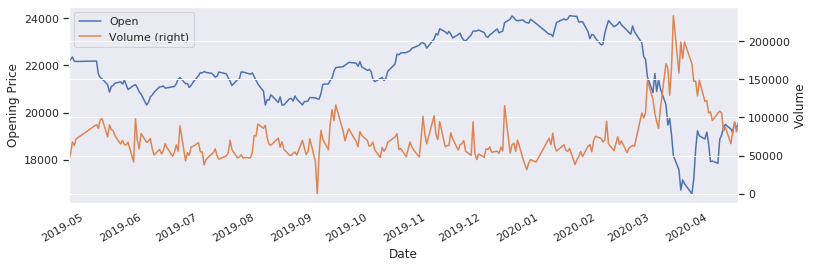

In [6]:
ax = df[['Open', 'Volume']].plot(secondary_y=['Volume'], figsize=(12, 4))

ax.set_ylabel('Opening Price')
_ = ax.right_ax.set_ylabel('Volume')

次に Bokeh でローソク足チャートを描画します。取引日ごとに最高値と最安値を縦棒で表現し、始値と終値の関係を四角形で表現します。
Bokeh で描画するとグラフ右側にツールボックスが表示されます。ズーム・パン・リサイズなどを実行できます。画像として保存することもできます。
個別のデータを確認する場合は虫眼鏡アイコン (Box Zoom) の機能を使って対象範囲を選択してみてください。

移動平均を計算したり、週ごとや月ごとに集計してプロットしてみると傾向が分かりやすくなるかもしれません。 ギャラリーの [stocks](https://docs.bokeh.org/en/latest/docs/gallery/stocks.html) も参考にしてください。
また、上記の *matplotlib* での例のように取引量 (Volume) を右軸に描画すると情報量が増えますので試してみてください。

In [7]:
inc = df['Open'] < df['Close']
dec = df['Open'] > df['Close']
w = 12*60*60*1000 # half day in ms

p = bplt.figure(title='日経平均株価指数の推移', x_axis_type='datetime', plot_width=640, plot_height=320)
p.xaxis.major_label_orientation = math.pi/4
p.grid.grid_line_alpha = 0.3

p.segment(df.index, df['High'], df.index, df['Low'], color="black")
p.vbar(df.index[inc], w, df['Open'][inc], df['Close'][inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df.index[dec], w, df['Open'][dec], df['Close'][dec], fill_color="#F2583E", line_color="black")

bplt.show(p)

## 月ごとに集計

pandas には時系列情報のための [Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) が用意されています。 `resample` を使って日別のデータを週、月、四半期ごとに集計します。データ期間が長い場合には年ごとにも集計できます。利用可能な文字列は [DateOffset objects](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) で説明されています。

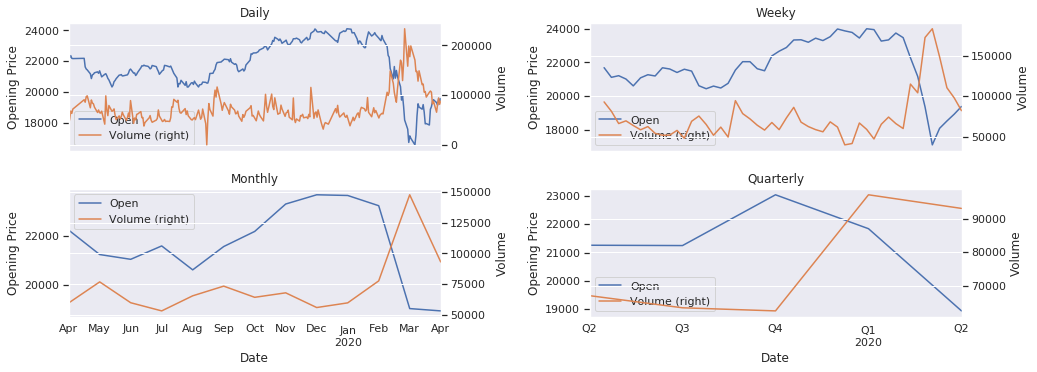

In [8]:
df0 = df[['Open', 'Volume']]
df1 = df.resample('W').apply({'Open': 'mean', 'Volume': 'mean'})
df2 = df.resample('M').apply({'Open': 'mean', 'Volume': 'mean'})
df3 = df.resample('Q').apply({'Open': 'mean', 'Volume': 'mean'})

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.4, hspace=0.3)

def subplot(data, ax, title):
    data.plot(ax=ax, secondary_y='Volume')
    ax.set_title(title)
    ax.set_ylabel('Opening Price')
    ax.right_ax.set_ylabel('Volume')

subplot(df0, axes[0][0], 'Daily')
subplot(df1, axes[0][1], 'Weeky')
subplot(df2, axes[1][0], 'Monthly')
subplot(df3, axes[1][1], 'Quarterly')

## データの変化量

取引日ごとの最高値と最低値をプロットし、高値と安値の変動幅を確認します。

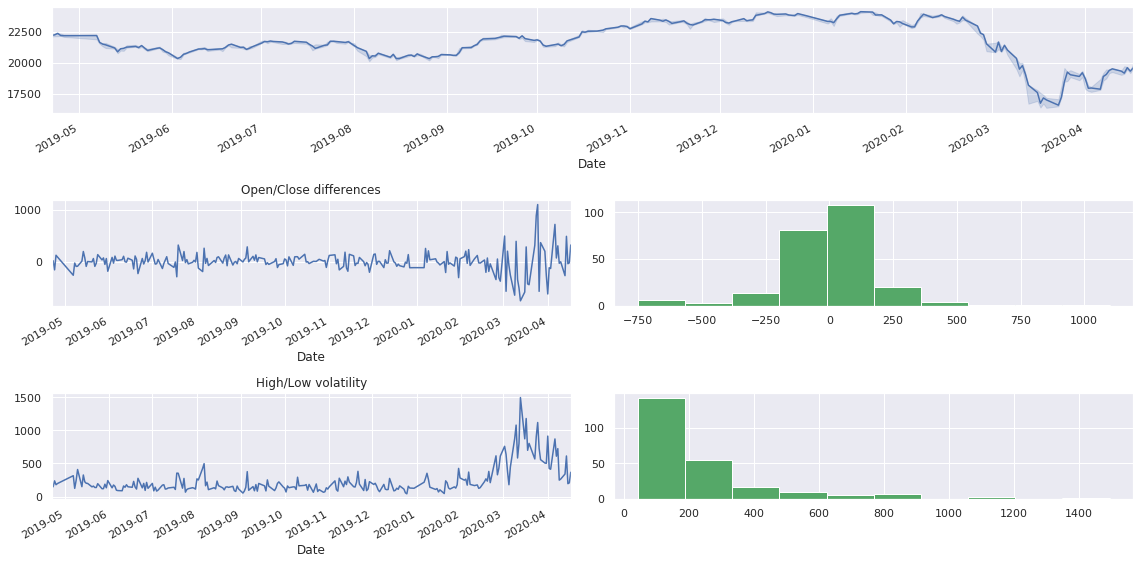

In [9]:
df['OpenClose'] = df['Close'] - df['Open']
df['LowHigh'] = df['High'] - df['Low']

fig = plt.figure(tight_layout=True, figsize=(16, 8))
gs = gridspec.GridSpec(3, 2)

ax = fig.add_subplot(gs[0, :])

ax.fill_between(df.index, df['Low'], df['High'], color='b', alpha=0.2)
df['Open'].plot(ax=ax)

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_title('Open/Close differences')
df['OpenClose'].plot(ax=ax1)
ax2 = fig.add_subplot(gs[1, 1])
df['OpenClose'].hist(ax=ax2, color='g')

ax3 = fig.add_subplot(gs[2, 0])
ax3.set_title('High/Low volatility')
df['LowHigh'].plot(ax=ax3)
ax4 = fig.add_subplot(gs[2, 1])
df['LowHigh'].hist(ax=ax4, color='g')

変化量の多い日と少ない日を確認します。

In [10]:
df.sort_values(['LowHigh'], ascending=False).head(5)

,High,Low,Open,Close,Volume,Adj Close,OpenClose,LowHigh
Date,,,,,,,,
2020-03-13,18184.460938,16690.599609,18183.470703,17431.050781,233400,17431.050781,-752.419922,1493.861328
2020-03-17,17557.039062,16378.940430,16726.949219,17011.529297,198800,17011.529297,284.580078,1178.098633
2020-03-25,19564.380859,18446.800781,18446.800781,19546.630859,147700,19546.630859,1099.830078,1117.580078
2020-03-10,19970.349609,18891.769531,19474.890625,19867.119141,164700,19867.119141,392.228516,1078.580078
2020-04-01,18784.250000,17871.619141,18686.119141,18065.410156,105800,18065.410156,-620.708984,912.630859


In [11]:
df.sort_values(['LowHigh']).head(5)

,High,Low,Open,Close,Volume,Adj Close,OpenClose,LowHigh
Date,,,,,,,,
2019-12-25,23824.849609,23782.869141,23813.589844,23782.869141,31600,23782.869141,-30.720703,41.980469
2020-01-20,24108.109375,24061.669922,24080.679688,24083.509766,38300,24083.509766,2.830078,46.439453
2019-09-02,20667.560547,20614.289062,20625.750000,20620.189453,42400,20620.189453,-5.560547,53.271484
2019-12-24,23853.560547,23796.349609,23839.179688,23830.580078,37900,23830.580078,-8.599609,57.210938
2019-10-21,22581.279297,22515.730469,22541.220703,22548.900391,48400,22548.900391,7.679688,65.548828


これらの情報を Bokeh で描画すると、個別のデータポイントの確認が簡単になります。ダッシュボードをなどを構築する際には検討してみてください。